## Fine-tuning Clip on Flickr Image Dataset


The following graph shows the approach, where basically we need an image an text encoder to compute representations on each source and compute similarities later on

![image.png](https://miro.medium.com/max/786/1*tg7akErlMSyCLQxrMtQIYw.png)

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [15]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 149.8 kB/s eta 0:00:00a 0:00:01
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-t6mkd3w_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-t6mkd3w_
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=4a2a53e48db9fde74bc147a54ca9d225b213922c88264e2b566ab7ddbff45ff3
  Stored in directory: /tmp/pip-ephem-wheel-cache-2vo8bfjs/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [17]:
import numpy as np
import clip
import torch
from tqdm.notebook import tqdm
from pkg_resources import packaging
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, BatchSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
print("Torch version:", torch.__version__)

Torch version: 1.11.0


## Load Model & Data

In [48]:
#preprocess is just a sequential module
model, preprocess = clip.load("ViT-B/32")

100%|███████████████████████████████████████| 338M/338M [02:35<00:00, 2.27MiB/s]


In [39]:
## Get labels
from pathlib import Path
import pandas as pd
labels=pd.read_csv("/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv",sep="|")
labels.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [40]:
# keep the first caption per image and use only 20% of the data for training
labels=labels[~labels.duplicated(subset="image_name",keep="first")].sample(frac=0.3)
labels['captions']=labels[' comment'].map(lambda d: d.strip())

In [41]:
train,test=train_test_split(labels,train_size=0.7)
##make sure when using ImageFolder, idx positions match, ImageFolder will load files in ascending order by filename
train.sort_values(by="image_name",ascending=True,inplace=True)
test.sort_values(by="image_name",ascending=True,inplace=True)
print(train.shape,test.shape)

(6674, 4) (2861, 4)


### Copy files to a new directory to load them using torch.datasets api

In [46]:
import shutil
import os
from tqdm import tqdm

BASE_PATH="/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images"

if not os.path.isdir("/kaggle/working/flickr-image-dataset/train/images"):
    os.makedirs("/kaggle/working/flickr-image-dataset/train/images")

if not os.path.isdir("/kaggle/working/flickr-image-dataset/test/images"):
    os.makedirs("/kaggle/working/flickr-image-dataset/test/images")
        
for image in tqdm(train.image_name,desc="Copying train images"):
    shutil.copyfile(Path(BASE_PATH)/image,Path("/kaggle/working/flickr-image-dataset/train/images")/image)

for image in tqdm(test.image_name,desc="Copying test images"):
    shutil.copyfile(Path(BASE_PATH)/image,Path("/kaggle/working/flickr-image-dataset/test/images")/image)

Copying test images: 100%|██████████| 2861/2861 [00:23<00:00, 122.51it/s]


In [50]:
#using datasets.ImageFolder makes loading images and preprocessing easier
train_images = datasets.ImageFolder("/kaggle/working/flickr-image-dataset/train/",transform=preprocess)
test_images = datasets.ImageFolder("/kaggle/working/flickr-image-dataset/test/",transform=preprocess)

In [51]:
## Create datasets

class FlickerDataset(Dataset):
    def __init__(self,captions,image_tensors):
        self.captions=captions
        self.images=image_tensors
        
    def __getitem__(self,idx):
        image_idx,_=self.images[idx]
        caption_idx=self.captions[idx]
        return {'image':image_idx,'caption':caption_idx}
        
    def __len__(self):
        return len(self.captions)
    
train_dataset = FlickerDataset(train.captions.values.tolist(), train_images)
test_dataset = FlickerDataset(test.captions.values.tolist(), test_images)
len(train_dataset), len(test_dataset)


(6674, 2861)

In [52]:
## create dataloaders
BATCH_SIZE=32
tr_dl=DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE)
ts_dl=DataLoader(test_dataset,shuffle=True,batch_size=BATCH_SIZE)

In [72]:
import torch.nn as nn
import torch.optim as optim

N_EPOCHS=20
loss_img = nn.CrossEntropyLoss()
loss_caption = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(tr_dl)*N_EPOCHS)

## Train Loop and validation

In [73]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

model.to(DEVICE)


## to avoid problems with mixed precision, taken from here https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float()

def train_model(n_epochs,train_dataloader,test_dataloader,checkpoint_path:str="./checkpoints"):
    if not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)
        
    print(f"Using {DEVICE} for training")
    best_score=-9e10
    history={'train_loss':[],'val_loss':[]}
    train_loss=0.0
    for epoch in tqdm(range(n_epochs)):
        total_steps=0
        model.train()
        for step,data in enumerate(train_dataloader,1):
            
            optimizer.zero_grad()
            
            img_batch=data['image'].to(DEVICE)
            captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
            with torch.cuda.amp.autocast():
                logits_image, logits_caption = model(img_batch, captions_batch)
            labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
            img_loss=loss_img(logits_image,labels)
            caption_loss=loss_caption(logits_caption,labels)
            total_loss = (img_loss+caption_loss)/2
            total_loss.backward()
            train_loss+=total_loss.item()
            convert_models_to_fp32(model)
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            total_steps+=1
            
            if step%100==0:
                print(f"Epoch {epoch} step loss:{train_loss/total_steps}")
                
        history['train_loss'].append(train_loss/len(train_dataloader))
        val_metrics=validate(test_dataloader)
        history['val_loss'].append(val_metrics)
        if val_metrics>best_score:
            print("Better score reached, saving checkpoint...")
            best_score=val_metrics
            torch.save(model.state_dict(), Path(checkpoint_path)/"best_model.pt")
            
        
        scheduler.step() ##per epoch scheduler
    return history
            
        
def validate(test_dl):
    model.eval()
    test_loss=0.0
    for data in tqdm(test_dl,desc="Evaluating in validation set"):
        img_batch=data['image'].to(DEVICE)
        captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
        with torch.no_grad():
            logits_image, logits_caption = model(img_batch, captions_batch)
        labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
        total_loss = (loss_img(logits_image,labels) + loss_caption(logits_caption,labels))/2
        test_loss+=total_loss.item()
    
    test_total_loss=test_loss/len(test_dl)
    print(f"Validation Loss {test_total_loss:.3f}")
    return test_total_loss
    

results=train_model(N_EPOCHS,tr_dl,ts_dl)

Using cuda:0 for training


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 step loss:0.031050150394439698
Epoch 0 step loss:0.029143409729003908



Evaluating in validation set: 100%|██████████| 90/90 [00:34<00:00,  2.59it/s]


Validation Loss 0.310
Better score reached, saving checkpoint...


  5%|▌         | 1/20 [02:42<51:21, 162.17s/it]

Epoch 1 step loss:0.08649353981018067
Epoch 1 step loss:0.05505821108818054



Evaluating in validation set: 100%|██████████| 90/90 [00:34<00:00,  2.59it/s]


Validation Loss 0.322
Better score reached, saving checkpoint...


 10%|█         | 2/20 [05:24<48:36, 162.00s/it]

Epoch 2 step loss:0.13204633831977844
Epoch 2 step loss:0.08095425546169281



Evaluating in validation set: 100%|██████████| 90/90 [00:34<00:00,  2.60it/s]


Validation Loss 0.327
Better score reached, saving checkpoint...


 15%|█▌        | 3/20 [08:05<45:52, 161.90s/it]

Epoch 3 step loss:0.19316881775856018
Epoch 3 step loss:0.10948289573192596



Evaluating in validation set: 100%|██████████| 90/90 [00:34<00:00,  2.58it/s]


Validation Loss 0.355
Better score reached, saving checkpoint...


 20%|██        | 4/20 [10:47<43:07, 161.72s/it]

Epoch 4 step loss:0.250768187046051
Epoch 4 step loss:0.1394324779510498



 25%|██▌       | 5/20 [13:27<40:19, 161.30s/it]

Validation Loss 0.333
Epoch 5 step loss:0.3003051108121872
Epoch 5 step loss:0.16052446722984315



Evaluating in validation set: 100%|██████████| 90/90 [00:34<00:00,  2.57it/s]


Validation Loss 0.398
Better score reached, saving checkpoint...


 30%|███       | 6/20 [16:09<37:40, 161.46s/it]

Epoch 6 step loss:0.3381790137290955
Epoch 6 step loss:0.1767033463716507



 35%|███▌      | 7/20 [18:50<34:55, 161.16s/it]

Validation Loss 0.360
Epoch 7 step loss:0.37849144101142884
Epoch 7 step loss:0.19724639266729355



 40%|████      | 8/20 [21:30<32:11, 160.96s/it]

Validation Loss 0.359
Epoch 8 step loss:0.4114881509542465
Epoch 8 step loss:0.21739272207021712



Evaluating in validation set: 100%|██████████| 90/90 [00:34<00:00,  2.60it/s]


Validation Loss 0.423
Better score reached, saving checkpoint...


 45%|████▌     | 9/20 [24:12<29:32, 161.15s/it]

Epoch 9 step loss:0.45601519525051115
Epoch 9 step loss:0.23596096456050872



 50%|█████     | 10/20 [26:52<26:47, 160.73s/it]

Validation Loss 0.393
Epoch 10 step loss:0.49274856090545655
Epoch 10 step loss:0.2602783477306366



Evaluating in validation set: 100%|██████████| 90/90 [00:34<00:00,  2.59it/s]


Validation Loss 0.434
Better score reached, saving checkpoint...


 55%|█████▌    | 11/20 [29:33<24:07, 160.88s/it]

Epoch 11 step loss:0.5455358409881592
Epoch 11 step loss:0.2834433361887932



 60%|██████    | 12/20 [32:13<21:25, 160.69s/it]

Validation Loss 0.400
Epoch 12 step loss:0.5915104103088379
Epoch 12 step loss:0.3044126379489899



 65%|██████▌   | 13/20 [34:54<18:46, 160.87s/it]

Validation Loss 0.393
Epoch 13 step loss:0.6273774671554565
Epoch 13 step loss:0.3228972378373146



 70%|███████   | 14/20 [37:35<16:04, 160.69s/it]

Validation Loss 0.389
Epoch 14 step loss:0.6685430413484573
Epoch 14 step loss:0.3425994136929512



Evaluating in validation set: 100%|██████████| 90/90 [00:34<00:00,  2.58it/s]


Validation Loss 0.438
Better score reached, saving checkpoint...


 75%|███████▌  | 15/20 [40:17<13:25, 161.15s/it]

Epoch 15 step loss:0.7017266780138016
Epoch 15 step loss:0.36395527452230453



Evaluating in validation set: 100%|██████████| 90/90 [00:34<00:00,  2.58it/s]


Validation Loss 0.499
Better score reached, saving checkpoint...


 80%|████████  | 16/20 [42:59<10:45, 161.49s/it]

Epoch 16 step loss:0.7692373424768448
Epoch 16 step loss:0.3973147416114807



Evaluating in validation set: 100%|██████████| 90/90 [00:34<00:00,  2.58it/s]


Validation Loss 0.513
Better score reached, saving checkpoint...


 85%|████████▌ | 17/20 [45:41<08:04, 161.64s/it]

Epoch 17 step loss:0.8146242481470108
Epoch 17 step loss:0.41695900589227675



 90%|█████████ | 18/20 [48:22<05:22, 161.46s/it]

Validation Loss 0.460
Epoch 18 step loss:0.8457440447807312
Epoch 18 step loss:0.42832555651664733



 95%|█████████▌| 19/20 [51:04<02:41, 161.49s/it]

Validation Loss 0.407
Epoch 19 step loss:0.8724679565429687
Epoch 19 step loss:0.4459857061505318



100%|██████████| 20/20 [53:44<00:00, 161.23s/it]

Validation Loss 0.443


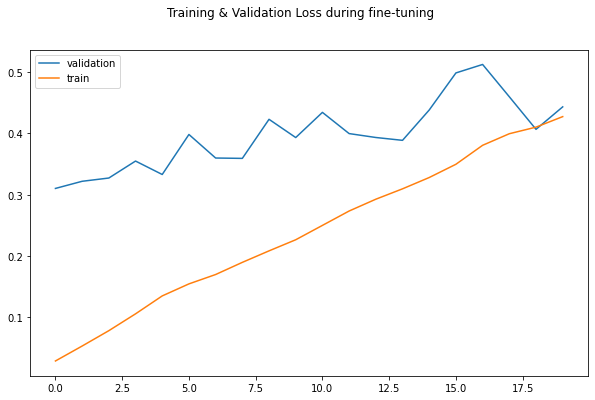

In [74]:
## lets see loss
f,ax=plt.subplots(figsize=(10,6))
plt.plot(results['val_loss'],label="validation")
plt.plot(results['train_loss'],label="train")
plt.legend()
plt.suptitle("Training & Validation Loss during fine-tuning");